# Visualisation and preparation

In [1]:
install.packages('Rtsne')

Installing package into ‘/usr/local/lib/R/4.0/site-library’
(as ‘lib’ is unspecified)



In [72]:
data = read.table("heart", sep = " ")
head(data)

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
1,70,1,4,130,322,0,2,109,0,2.4,2,3,3,2
2,67,0,3,115,564,0,2,160,0,1.6,2,0,7,1
3,57,1,2,124,261,0,0,141,0,0.3,1,0,7,2
4,64,1,4,128,263,0,0,105,1,0.2,2,1,7,1
5,74,0,2,120,269,0,2,121,1,0.2,1,1,3,1
6,65,1,4,120,177,0,0,140,0,0.4,1,0,7,1


In [76]:
#separate data for train and test
get_train_test <- function(data, persentage) {
    size = dim(data)[1]
    set.seed(12345)
    randomized = data[order(runif(size)), ]
    train_sep = as.integer(size * persentage / 100)
    test_sep = as.integer(size * (1 - persentage / 100))
    list(randomized[1 : train_sep, ], randomized[(test_sep + 1) : size, ])
}

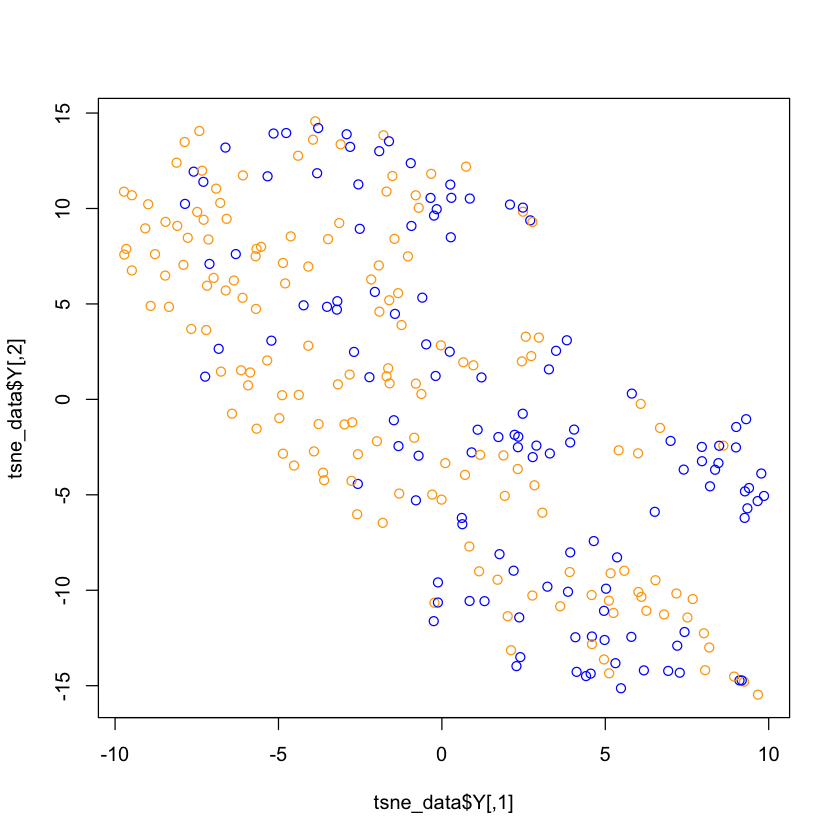

In [77]:
library(Rtsne)

tsne_data = Rtsne(data)
plot(tsne_data$Y, col=c('orange', 'blue')[data$V14])

# 1 

In [78]:
data$V14 <- as.factor(data$V14)

#test the function
separated_data = get_train_test(data, 75)
train = separated_data[[1]]
test = separated_data[[2]]

# knn

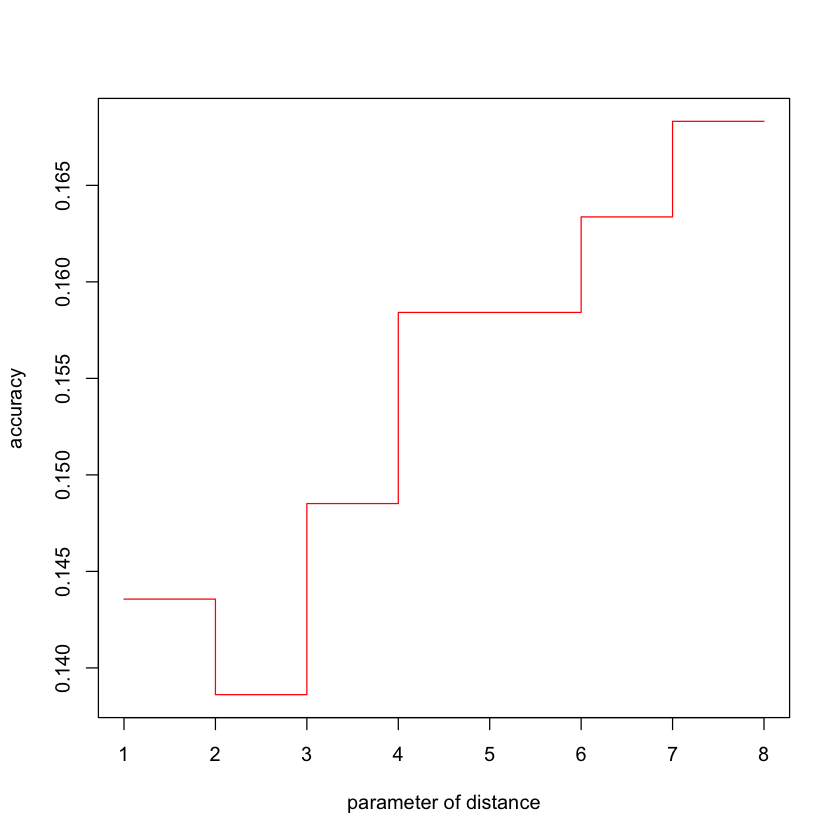

[1] 0.1182266


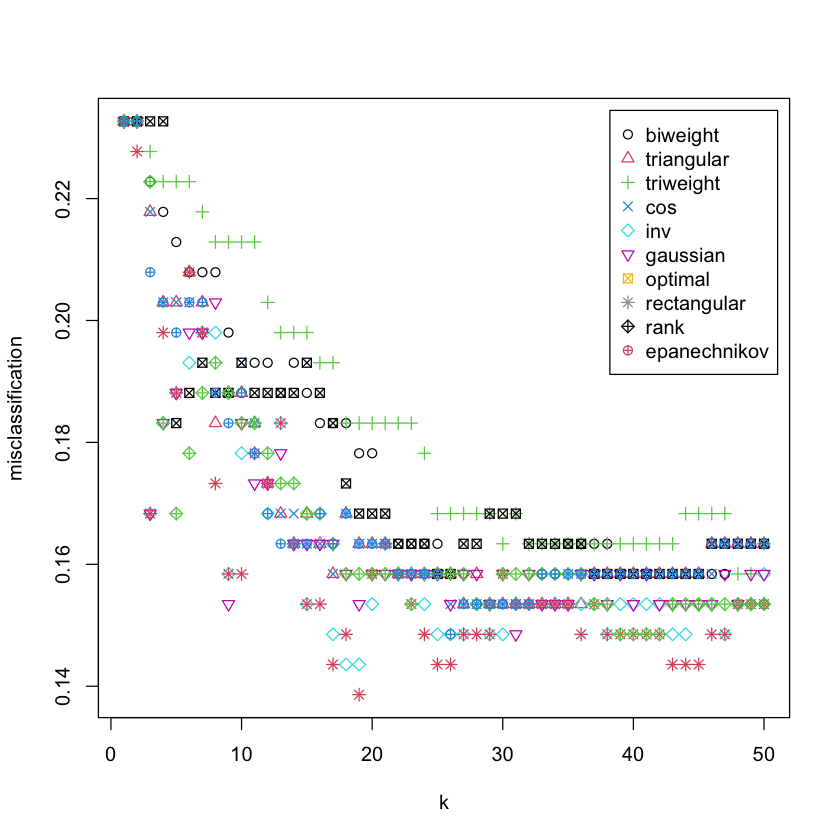

In [91]:
library(kknn)

distance_test <- function(data, distances) {
    test <- function(distance) { 
        classifier = train.kknn(V14 ~ ., 
                                data = data, 
                                kmax = 50, 
                                kernel = c("biweight", "triangular", "triweight", "cos", "inv", "gaussian",
                                 "optimal", "rectangular", "rank", "epanechnikov"), 
                                distance = distance) 
        classifier[['MISCLASS']][classifier[["best.parameters"]]$k, classifier[["best.parameters"]]$kernel]
    }
    
    sapply(distances, function(distance) { test(distance)})
}

distances = seq(1, 8, by=1)

plot(distances, distance_test(train, distances), type = 's', xlab = 'parameter of distance', ylab = 'accuracy', col = 'red')


k_kernel_test <- function(data) {
  classifier = train.kknn(V14 ~ ., 
                      data = data, 
                      kmax = 50, 
                      kernel = c("biweight", "triangular", "triweight", "cos", "inv", "gaussian",
                                 "optimal", "rectangular", "rank", "epanechnikov"),
                      distance = 2)
  plot(classifier)
}

k_kernel_test(train)

model = kknn(V14 ~ ., train, test, k = 19, kernel = 'rectangular', distance = 2)
predicted = fitted(model)
print(1 - sum(diag(table(predicted, test$V14))) / nrow(test))


# svm

In [97]:
library(e1071)

get_error <- function(kernel) {
  svm_clsfr = svm(V14 ~ ., 
                   data = train,
                   type = "C-classification",
                   cost = 1,
                   kernel = kernel)
  
    pred = predict(svm_clsfr, test)
    tbl = table(pred, test$V14)
    return(1. - sum(diag(tbl)) / nrow(test))
}

kernels = c("polynomial", "radial", "sigmoid")
errors = sapply(kernels, function(kernel) {get_error(kernel)})

print(errors)

get_min_error <- function(errors, kernels) {
    max = 1
    current_position = 1
    
    sapply(errors, function(error) { max <<- if(error < errors[max]) current_position else max
                                    current_position <<- current_position + 1
                                    })
    kernels[max]
}


get_pol_error <- function(degree) {
  svm_clsfr = svm(V14 ~ ., 
                   data = train,
                   type = "C-classification",
                   cost = 1,
                   kernel = "polynomial",
                   degree = degree)
  
    pred = predict(svm_clsfr, test)
    tbl = table(pred, test$V14)
    return(1. - sum(diag(tbl)) / nrow(test))
}

for (deg in 1:20) {
  print(paste('Degree ', deg, ' - ', get_pol_error(deg)))
}

polynomial     radial    sigmoid 
0.08866995 0.09359606 0.15270936 
[1] "Degree  1  -  0.137931034482759"
[1] "Degree  2  -  0.201970443349754"
[1] "Degree  3  -  0.0886699507389163"
[1] "Degree  4  -  0.192118226600985"
[1] "Degree  5  -  0.142857142857143"
[1] "Degree  6  -  0.206896551724138"
[1] "Degree  7  -  0.197044334975369"
[1] "Degree  8  -  0.231527093596059"
[1] "Degree  9  -  0.221674876847291"
[1] "Degree  10  -  0.251231527093596"
[1] "Degree  11  -  0.251231527093596"
[1] "Degree  12  -  0.25615763546798"
[1] "Degree  13  -  0.25615763546798"
[1] "Degree  14  -  0.25615763546798"
[1] "Degree  15  -  0.25615763546798"
[1] "Degree  16  -  0.25615763546798"
[1] "Degree  17  -  0.25615763546798"
[1] "Degree  18  -  0.261083743842365"
[1] "Degree  19  -  0.25615763546798"
[1] "Degree  20  -  0.261083743842365"


# naive Bayes

 [1] 0.1182266 0.1182266 0.1182266 0.1182266 0.1182266 0.1182266 0.1182266
 [8] 0.1182266 0.1182266 0.1182266 0.1182266


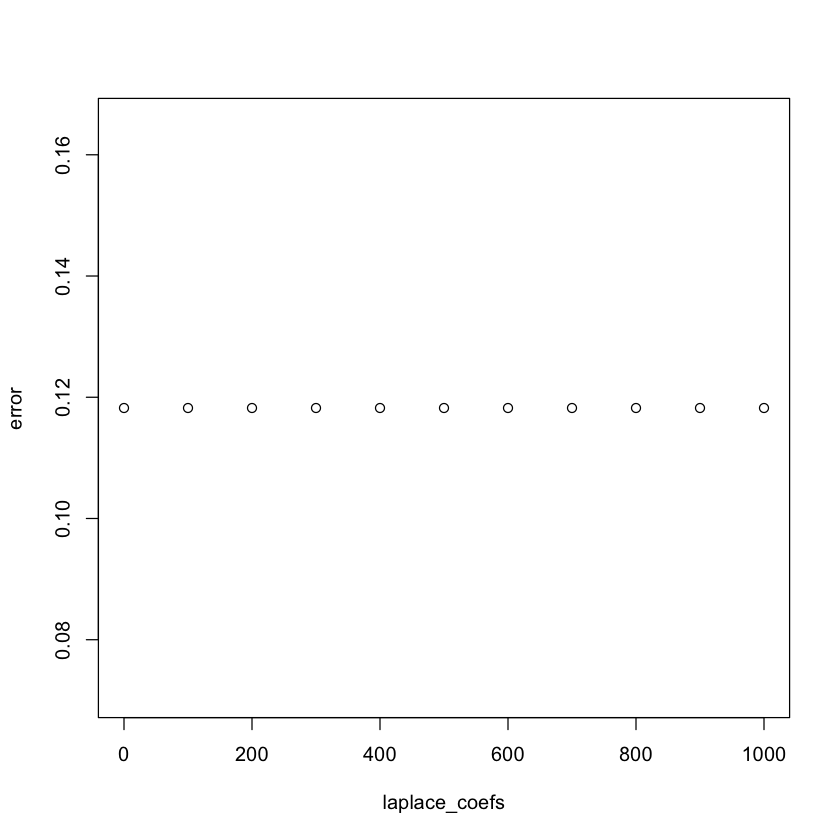

In [129]:
get_accuracy <- function(laplace) {
    classifier = naiveBayes(V14 ~ ., train, laplace=laplace)
    predicted = predict(classifier, test)
    result = table(predicted, test$V14)
    1 - (result[[1]] + result[[4]]) / nrow(test)
}

laplace_coefs = seq(0, 3, 0.5)
error = sapply(laplace_coefs, get_accuracy)

plot(laplace_coefs, error)
print(error)

# 2

SVM the best

# 3

In [104]:
labels = data$V14
data = data[, -14]
head(data)
print(labels)

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,70,1,4,130,322,0,2,109,0,2.4,2,3,3
2,67,0,3,115,564,0,2,160,0,1.6,2,0,7
3,57,1,2,124,261,0,0,141,0,0.3,1,0,7
4,64,1,4,128,263,0,0,105,1,0.2,2,1,7
5,74,0,2,120,269,0,2,121,1,0.2,1,1,3
6,65,1,4,120,177,0,0,140,0,0.4,1,0,7


  [1] 2 1 2 1 1 1 2 2 2 2 1 1 1 2 1 1 2 2 1 1 2 1 1 1 1 1 1 1 2 1 2 1 1 2 2 2 2
 [38] 2 1 1 2 1 1 1 2 1 2 2 2 2 2 1 1 1 1 1 2 1 2 2 1 2 1 1 1 2 1 2 1 2 2 1 1 1
 [75] 1 2 1 1 1 1 2 2 2 1 1 1 1 1 1 2 1 2 2 2 2 2 1 2 1 1 1 2 1 2 2 2 1 2 2 1 2
[112] 1 2 1 1 1 2 2 1 2 2 2 2 1 1 1 2 1 1 2 2 2 1 2 1 1 1 2 1 1 2 1 2 1 2 2 2 2
[149] 2 1 1 1 1 1 1 1 2 1 1 2 2 2 1 2 1 1 1 1 1 2 1 2 2 1 1 2 2 2 2 1 1 2 2 1 1
[186] 1 2 1 1 2 1 2 1 2 1 1 1 1 1 2 1 2 2 2 2 1 1 1 2 1 2 1 1 2 1 1 1 1 1 1 2 2
[223] 1 2 1 1 2 2 1 1 2 2 1 2 1 2 1 2 1 1 2 1 1 2 1 2 2 1 2 2 2 1 2 1 1 1 1 2 2
[260] 1 1 2 2 1 2 1 1 1 1 2
Levels: 1 2


[1] 0.837037


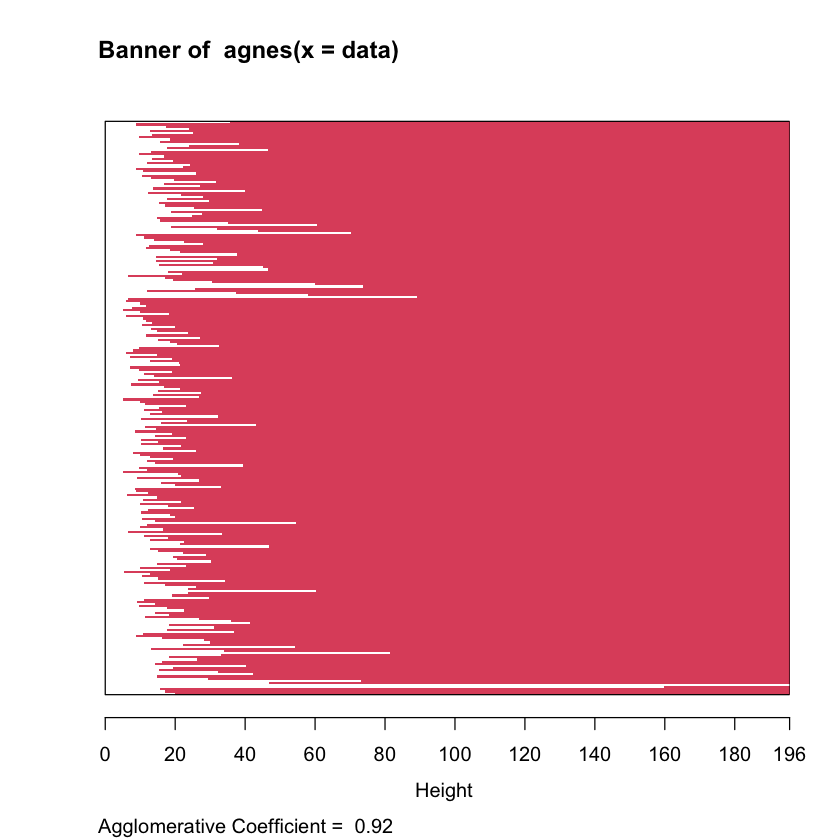

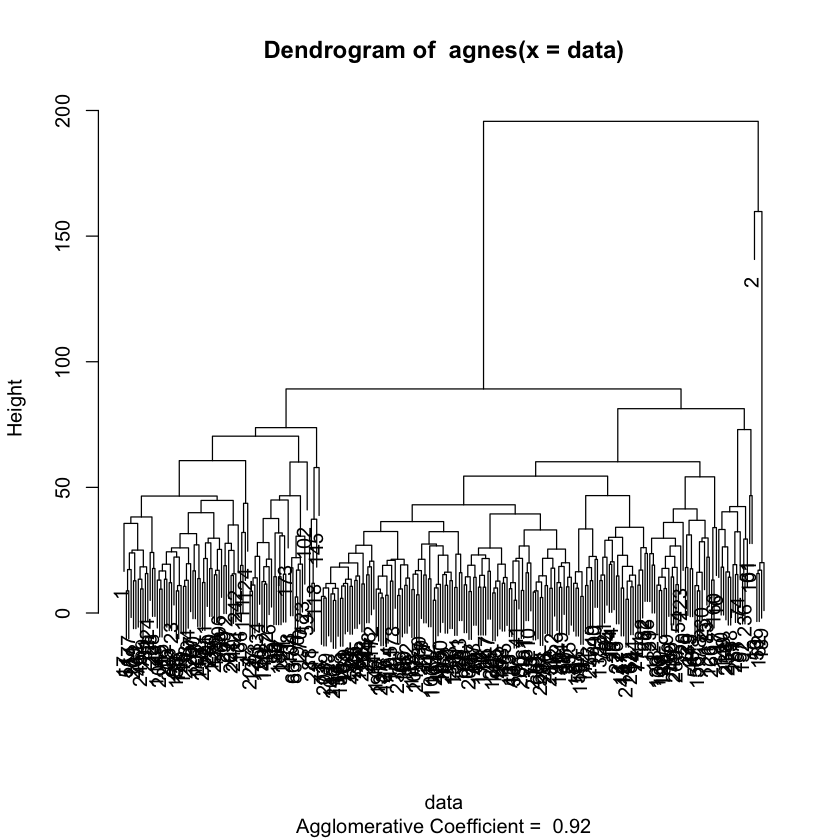

In [127]:
library(cluster)

clusteriser=clara(data, 2, metric = "euclidean", stand = TRUE)
# works only for binary clustering
print(1 - sum(labels == clusteriser$clustering) / length(labels))

library(cluster)
plot(agnes(data))